# Face Recognition on Olivetti Dataset

I'm oging to perform face recognition, using the Olivetti Dataset I'll use some machine learning algorithsm, to associate people's names with their photos.

Brief information about Olivetti Dataset:

* There are ten different image of each of 40 distinct people, their names are encoded to integers from 0 to 39;
* There are 400 face images in the dataset;
* There are differences between photos, like glasses or expressions;
* Size of each image is 64x64;
* Image pixel values were scaled to [0, 1] interval.

# Packages Import  
I'm importing all  the packages I'll need during the analysis.

In [28]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#Visualization
import matplotlib.pyplot as plt

#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics
import tensorflow as tf

# Data Import and Description  
I'm importing all the photos with their labels and giving a brief description of the dataset.

In [29]:
data=np.load("C:/Users/lucaf/OneDrive/Desktop/Codici/Python/Data_Recognition/olivetti_faces.npy")
target=np.load("C:/Users/lucaf/OneDrive/Desktop/Codici/Python/Data_Recognition/olivetti_faces_target.npy")

In [30]:
print("There are {} images in the dataset".format(len(data)))
print("There are {} unique targets in the dataset".format(len(np.unique(target))))
print("Size of each image is {}x{}".format(data.shape[1],data.shape[2]))
print("Pixel values were scaled to [0,1] interval. e.g:{}".format(data[0][0,:4]))

There are 400 images in the dataset
There are 40 unique targets in the dataset
Size of each image is 64x64
Pixel values were scaled to [0,1] interval. e.g:[0.30991736 0.3677686  0.41735536 0.44214877]


I'm going to use a simple function to print a photo for each person in the dataset.

In [31]:
def Photo_per_Person(images, unique_ids):
    fig, axarr=plt.subplots(nrows=4, ncols=10, figsize=(18, 9))
    axarr=axarr.flatten()
    
    for unique_id in unique_ids:
        image_index=unique_id*10
        axarr[unique_id].imshow(images[image_index], cmap='magma')
        axarr[unique_id].set_xticks([])
        axarr[unique_id].set_yticks([])
        axarr[unique_id].set_title("face id:{}".format(unique_id))
    plt.suptitle("There are 40 distinct photo in the dataset")

I decided to use the 'Magma' color set, but is just appearance real photos are in gray scale.

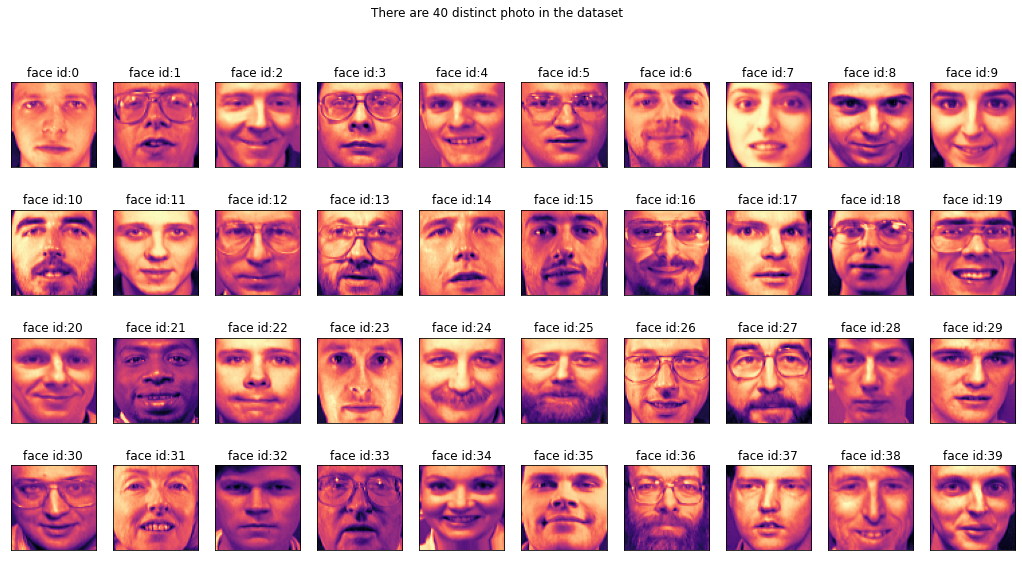

In [32]:
Photo_per_Person(data, np.unique(target))

# Data Preparation  
I'll reshape data for analysis and divide data in train and test, in particoulare I'll use 30% of the Dataset as a test set and all the remaining as train set.

In [33]:
X=data.reshape((data.shape[0],data.shape[1]*data.shape[2]))

In [34]:
X_train, X_test, y_train, y_test=train_test_split(X, target, test_size=0.3, stratify=target, random_state=0)

## PCA  
I'll perform PCA to reduce the number of features.  
PCA reduce the total number of components using a small number of not observed features in place of the observed ones in the dataset.

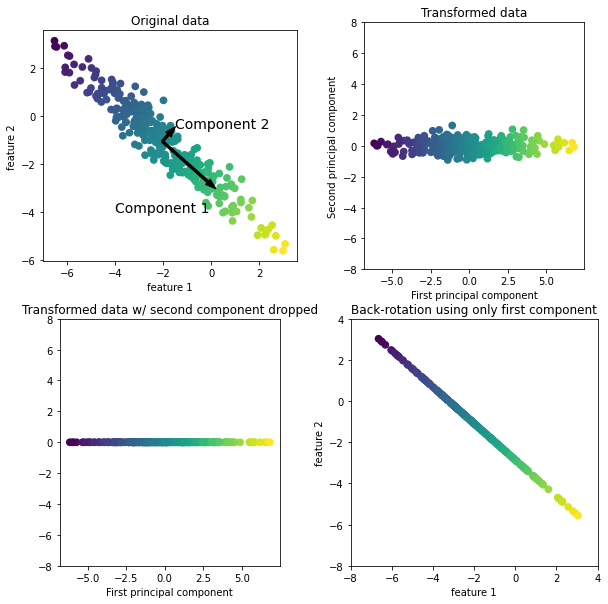

In [35]:
import mglearn
mglearn.plots.plot_pca_illustration()

In [36]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
pca.fit(X)
X_pca=pca.transform(X)

Projection of the people's photo on the first two principal components.

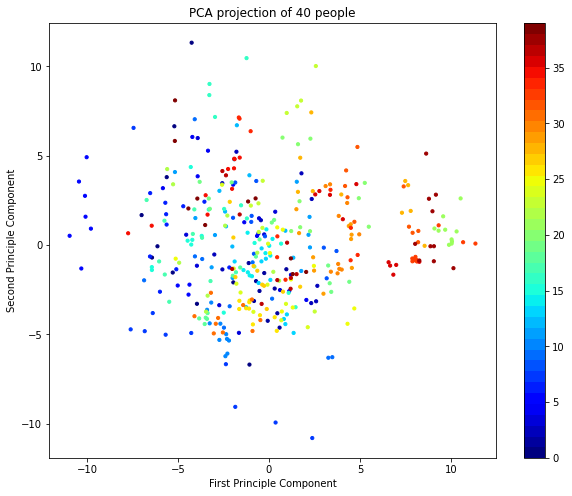

In [37]:
number_of_people=40
index_range=number_of_people*40
fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot(1,1,1)
scatter=ax.scatter(X_pca[:index_range,0],
            X_pca[:index_range,1], 
            c=target[:index_range],
            s=10,
           cmap=plt.get_cmap('jet', number_of_people)
          )

ax.set_xlabel("First Principle Component")
ax.set_ylabel("Second Principle Component")
ax.set_title("PCA projection of {} people".format(number_of_people))

fig.colorbar(scatter)

All components created with PCA have to explain a quote of the Varance in the Features of the Dataset, I'll plot the Explained Variance and the Components number in order to select the right number.  
There isn't a precise rule, but it's better to select the minimum number which explains the maximum possible of Variance.  
In practice, it's better to chose the number of components in which the graphic stops falling vertically.

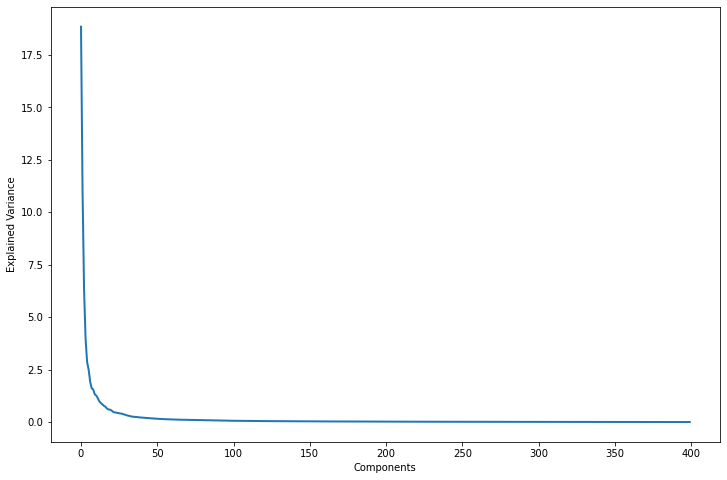

In [38]:
pca=PCA()
pca.fit(X)

plt.figure(1, figsize=(12,8))

plt.plot(pca.explained_variance_, linewidth=2)
 
plt.xlabel('Components')
plt.ylabel('Explained Variance')
plt.show()

I'll take 40 Components, it's an too high number of components, in the future it's intresting to see if,and how, results change using a different number of components.

In [39]:
pca=PCA(n_components=40, whiten=True)
pca.fit(X_train)

PCA(n_components=40, whiten=True)

Using the result of the PCA I can plot the average face in the dataset, using grayscale.

Text(0.5, 1.0, 'Average Face')

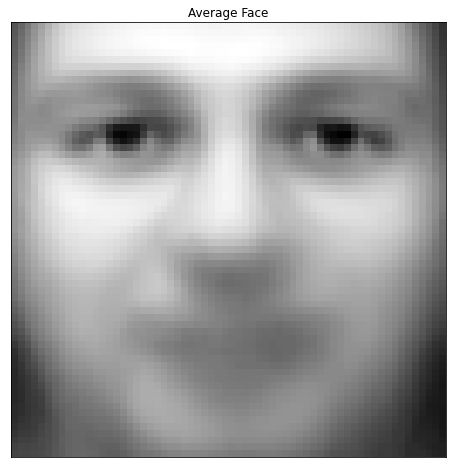

In [40]:
fig,ax=plt.subplots(1,1,figsize=(8,8))
ax.imshow(pca.mean_.reshape((64,64)), cmap="gray")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Average Face')

Photo reconstructed using PCA data.  
Not all of them are clear as the original version, but it's a good result.

Text(0.5, 0.98, 'All Eigen Faces')

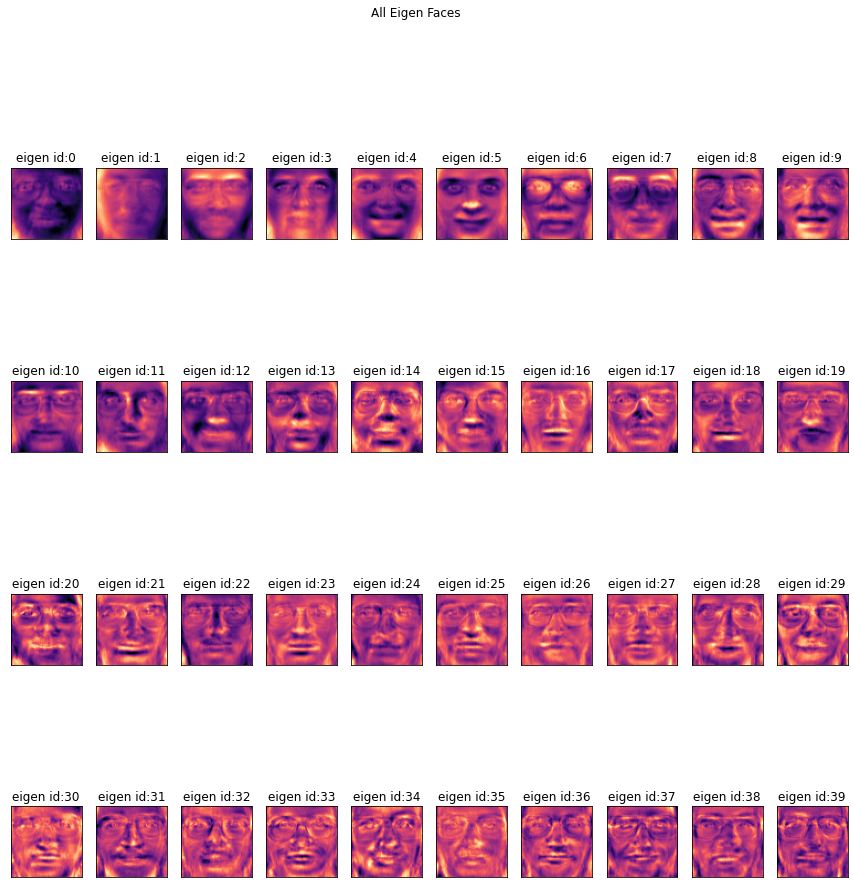

In [41]:
number_of_eigenfaces=len(pca.components_)
eigen_faces=pca.components_.reshape((number_of_eigenfaces, data.shape[1], data.shape[2]))

cols=10
rows=int(number_of_eigenfaces/cols)
fig, axarr=plt.subplots(nrows=rows, ncols=cols, figsize=(15,15))
axarr=axarr.flatten()
for i in range(number_of_eigenfaces):
    axarr[i].imshow(eigen_faces[i],cmap="magma")
    axarr[i].set_xticks([])
    axarr[i].set_yticks([])
    axarr[i].set_title("eigen id:{}".format(i))
plt.suptitle("All Eigen Faces".format(10*"=", 10*"="))

I transform train and test using PCA.

In [42]:
X_train_pca=pca.transform(X_train)
X_test_pca=pca.transform(X_test)

The first model used for this classification task is an SVC, Support Vector Classification, a particoular type of SVM.

In [43]:
clf = SVC()
clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)
print("accuracy score:{:.2f}".format(metrics.accuracy_score(y_test, y_pred)))

accuracy score:0.92


The accuracy score on the Test in 0.92, a really good results.  
Now the plot of the confusion matrix.  
On the main diagonal there are the well-classified images.  
As is easy to see each person has two or three well classified photos and zero or one misclassified photo.  
Only the person labeled as **0** has a larger amount of misclassified than well-classified photos.

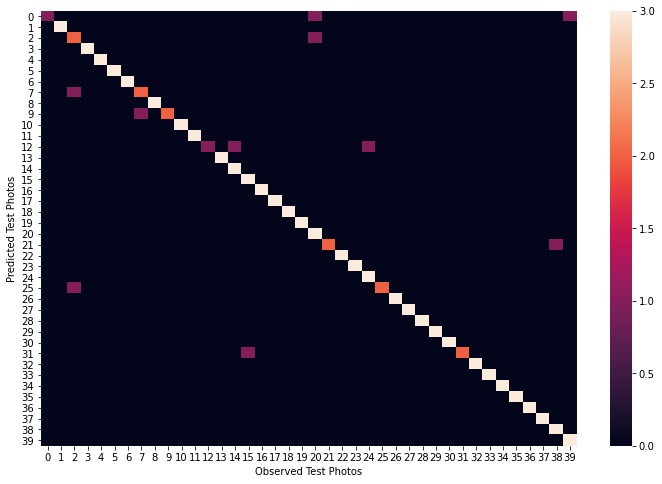

In [44]:
import seaborn as sns
plt.figure(1, figsize=(12,8))
p=sns.heatmap(metrics.confusion_matrix(y_test, y_pred))
p.set_xlabel('Observed Test Photos')
p.set_ylabel('Predicted Test Photos')
plt.show()

I'm now creating a confusion matrix, the result is a huge tab not clearly readable, but performing some random controls it confirms the really good performance of the model.

In [45]:
y_actual = pd.Series(y_test, name='Actual')
y_predicted = pd.Series(y_pred, name='Predicted')
df_confusion = pd.crosstab(y_actual, y_predicted)

print(df_confusion)

Predicted  0   1   2   3   4   5   6   7   8   9   ...  30  31  32  33  34  \
Actual                                             ...                       
0           1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
1           0   3   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
2           0   0   2   0   0   0   0   0   0   0  ...   0   0   0   0   0   
3           0   0   0   3   0   0   0   0   0   0  ...   0   0   0   0   0   
4           0   0   0   0   3   0   0   0   0   0  ...   0   0   0   0   0   
5           0   0   0   0   0   3   0   0   0   0  ...   0   0   0   0   0   
6           0   0   0   0   0   0   3   0   0   0  ...   0   0   0   0   0   
7           0   0   1   0   0   0   0   2   0   0  ...   0   0   0   0   0   
8           0   0   0   0   0   0   0   0   3   0  ...   0   0   0   0   0   
9           0   0   0   0   0   0   0   1   0   2  ...   0   0   0   0   0   
10          0   0   0   0   0   0   0   0   0   0  ...   0   0  

An evolution of this code is the use of a neural network to perform facial recognition and compare models.